In [27]:
import os
import copy
import json
import numpy as np
import pickle
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
import tqdm

import util_cochlea
import util_network
import util_stimuli
import util_figures


def azim_elev_to_label(azim, elev):
    """
    """
    label = (elev / 10) * 72 + (azim / 5)
    return np.array(label).astype(int)


def label_to_azim_elev(label):
    """
    """
    elev = np.array((label // 72) * 10)
    azim = np.array((label % 72) * 5)
    return np.array(azim).astype(float), np.array(elev).astype(float)


def normalize_angle(angle, lower=-180, upper=180):
    """
    Based on `normalize` function from:
    https://gist.github.com/phn/1111712/35e8883de01916f64f7f97da9434622000ac0390
    """
    assert lower < upper, f'Invalid lower and upper limits: [{lower}, {upper}]'
    normalized_angle = np.array(angle).copy()
    IDX_ABOVE = np.logical_or(angle > upper, angle == lower)    
    normalized_angle[IDX_ABOVE] = lower + np.mod(
        np.abs(angle[IDX_ABOVE] + upper),
        np.abs(lower) + np.abs(upper))
    IDX_BELOW = np.logical_or(angle < lower, angle == upper)
    normalized_angle[IDX_BELOW] = upper - np.mod(
        np.abs(angle[IDX_BELOW] - lower),
        np.abs(lower) + np.abs(upper))
    return normalized_angle


In [21]:
"""
Build tensorflow2 objects for the `network_model and the `cochlea_model`.

The `cochlea_model` has no learnable parameters and does not require a checkpoint to be loaded.
The `network_model` parameters are loaded from a checkpoint file.
"""
dir_model = 'models/tensorflow2/arch01'
fn_arch = os.path.join(dir_model, 'arch.json')
fn_config = os.path.join(dir_model, 'config.json')
fn_ckpt = os.path.join(dir_model, 'ckpt_BEST')

with open(fn_arch, 'r') as f:
    list_layer_dict = json.load(f)
with open(fn_config, 'r') as f:
    CONFIG = json.load(f)

def model_input_to_output_mapping(x):
    y = x
    if CONFIG.get('kwargs_cochlea', {}):
        msg = "expected input with shape [batch, time, channel=2]"
        assert (len(y.shape) == 3) and (y.shape[-1] == 2), msg
        # Cochlear model for ear index 0
        y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Cochlear model for ear index 1
        y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(CONFIG['kwargs_cochlea']))
        # Binaural cochlear model representation with shape [batch, freq, time, channel=2]
        y = tf.concat([y0[..., tf.newaxis], y1[..., tf.newaxis]], axis=-1)
        msg = "expected cochlear model output with shape [batch, freq, time, channel=2]"
        assert (len(y.shape) == 4) and (y.shape[-1] == 2), msg
    y, _ = util_network.build_network(y, list_layer_dict, n_classes_dict=CONFIG['n_classes_dict'])
    return y

tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(48000, 2), batch_size=None, dtype=tf.float32)
model = tf.keras.Model(
    inputs=inputs,
    outputs=model_input_to_output_mapping(inputs))
model.load_weights(fn_ckpt)
print('Loaded: {}'.format(fn_ckpt))


[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=39, time=48000]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 4000, 'numtaps': 4097, 'window': ['kaiser', 5.0]}
[fir_lowpass_filter] sr_filt = 48000 Hz
[fir_lowpass_filter] numtaps = 4097 samples
[fir_lowpass_filter] fir_dur = 0.08533333333333333 seconds
[fir_lowpass_filter] cutoff = 4000 Hz
[fir_lowpass_filter] window = ('kaiser', 5.0)
[cochlea] resampled subbands from 48000 Hz to 8000 Hz with filter: {'cutoff': 4000, 'numtaps': 4097, 'window': ['kaiser', 5.0]}
[cochlea] half-wave rectified resampled subbands
[cochlea] applied 0.3 power compression to subbands
[cochlea] converting audio to subbands using half_cosine_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=39, time=48000]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff'

In [22]:
"""
Build the activation collector model (wraps around original model to
return both the original output and the desirect layer's activation)
"""
activation_layer_name = "relu_1" # Layer whose activations to collect
activation_model = tf.keras.Model(
    inputs=model.input,
    outputs=[
        model.output,
        model.get_layer(activation_layer_name).output,
    ]
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 957.19it/s]


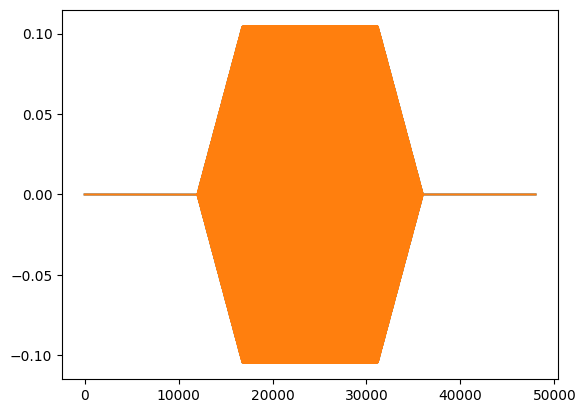

In [23]:
def get_brughera_stimulus(itd=0.0, f=1e3, sr=50000, dur=0.5, rise=0.1, dur_padded=1.3, dbspl=70.0):
    """
    Pure tone ITD stimulus with ramped envelope to avoid onset cues
    (similar to Brughera et al. 2013)
    """
    t = np.arange(0, dur, 1/sr)
    ramp = np.arange(0, rise, 1/sr) / rise
    envelope = np.ones_like(t)
    envelope[:len(ramp)] = ramp
    envelope[-len(ramp):] = ramp[::-1]
    phase = np.random.uniform(low=0, high=2 * np.pi)
    y0 = np.sin(2 * np.pi * f * (t - 0) + phase)
    y1 = np.sin(2 * np.pi * f * (t - itd) + phase)
    y = np.stack([y0, y1], axis=1) * envelope[:, np.newaxis]
    y = util_stimuli.set_dBSPL(y, dbspl)
    if dur_padded is not None:
        n_pad = (int(dur_padded * sr) - y.shape[0]) // 2
        y = np.pad(y, [(n_pad, n_pad), (0, 0)])
    return y


f = 1e3
sr = 48e3
dur = 0.5
rise = 0.1
dur_padded = 1.0
dbspl = 70.0

list_itd = np.arange(-160e-6, 160e-6 + 1e-9, 1e-6)
list_y = []
for itd in tqdm.tqdm(list_itd):
    y = get_brughera_stimulus(
        itd=itd,
        f=f,
        sr=sr,
        dur=dur,
        rise=rise,
        dur_padded=dur_padded,
        dbspl=dbspl,
    )
    list_y.append(y)
list_y = np.stack(list_y)
list_y.shape

fig, ax = plt.subplots()
ax.plot(y[:, 0])
ax.plot(y[:, 1])
plt.show()


In [24]:
batch_size = 8
list_prob = []
list_activation = []
for idx0 in tqdm.tqdm(np.arange(0, list_y.shape[0], batch_size)):
    idx1 = min(idx0 + batch_size, list_y.shape[0])
    out, act = activation_model(list_y[idx0 : idx1])
    prob = tf.nn.softmax(out['label_loc_int']).numpy()
    list_prob.append(prob)
    list_activation.append(act.numpy().mean(axis=2)) # Collect activation averaged over time axis (batch, freq, time, channel)
list_prob = np.concatenate(list_prob, axis=0)
list_activation = np.concatenate(list_activation, axis=0)
list_prob.shape, list_activation.shape


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  5.06it/s]


((321, 504), (321, 39, 32))

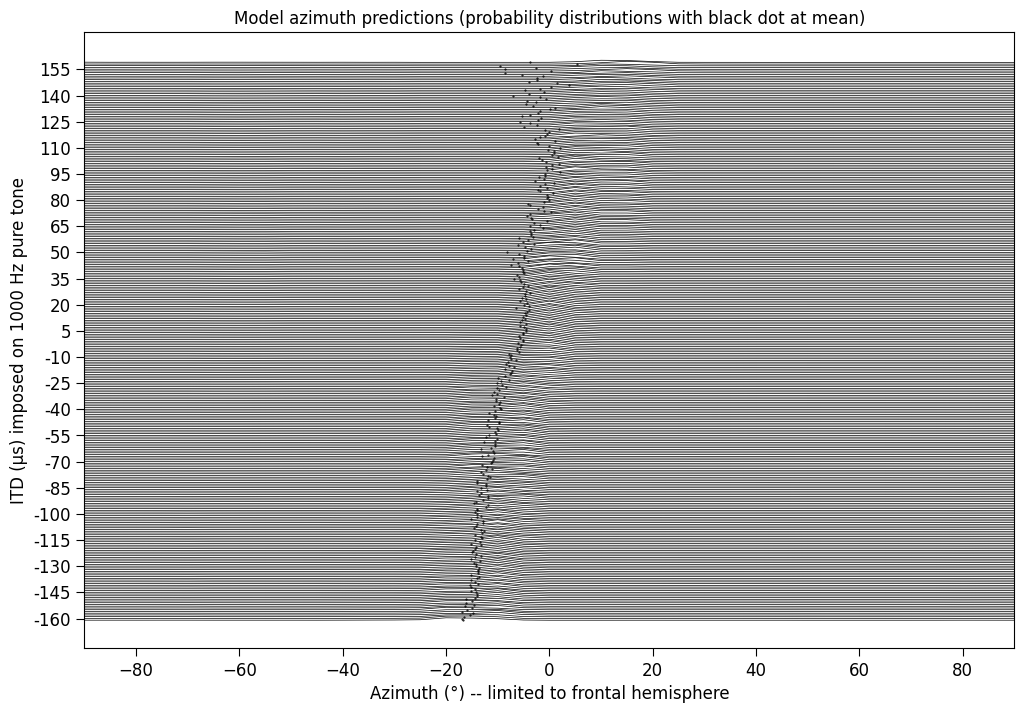

In [25]:
"""
Confirm the model has "perceptual" sensitivity to the ITDs in the given stimuli:
distribution of azimuth predictions should vary with ITD.

(also helpful to confirm the model checkpoint was correctly loaded)
"""

list_azim, list_elev = label_to_azim_elev(np.arange(0, 504))
list_azim = list_azim.reshape([7, -1]).mean(axis=0)
x = normalize_angle(list_azim)
SORT_IDX = np.argsort(x)
x = x[SORT_IDX]
INCLUDE_IDX = np.logical_and(x >= -90, x<= 90)
x = x[INCLUDE_IDX]

fig, ax = plt.subplots(figsize=(12, 8))
offset = 0
yticks = []
yticklabels = []
for itr, prob in enumerate(list_prob):
    y = prob.reshape([7, -1]).sum(axis=0)[SORT_IDX][INCLUDE_IDX]
    y = y / y.sum()
    x_mean = np.sum(y * x)
    ax.plot(
        x,
        y + offset,
        color="k",
        lw=0.5,
    )
    ax.plot(
        x_mean,
        offset,
        color="k",
        marker=".",
        ms=1,
    )
    offset += 1 / 5
    if itr % 15 == 0:
        yticks.append(offset)
        yticklabels.append(int(np.round(1e6 * list_itd[itr])))
ax = util_figures.format_axes(
    ax,
    xlimits=[-90, 90],
    yticks=yticks,
    yticklabels=yticklabels,
    str_xlabel="Azimuth (°) -- limited to frontal hemisphere",
    str_ylabel="ITD (µs) imposed on {:.0f} Hz pure tone".format(f),
    str_title="Model azimuth predictions (probability distributions with black dot at mean)",
)
plt.show()


Collected time-averaged activations: act.shape=(321, 39, 32) (n_itd, model_freq, model_channel)
Reshaped activations: act.shape=(321, 1248) (n_itd, `model_units`)
Excluded 123 units with no activity (averaged across all stimuli): act.shape=(321, 1125) (n_itd, `model_units`)
Sorted remaining 1125 units by amount of variance across stimuli: act.shape=(321, 1125) (n_itd, `model_units`)

Visualizing ITD tuning for the 80 most ITD-sensitive units in models/tensorflow2/arch01/relu_1:



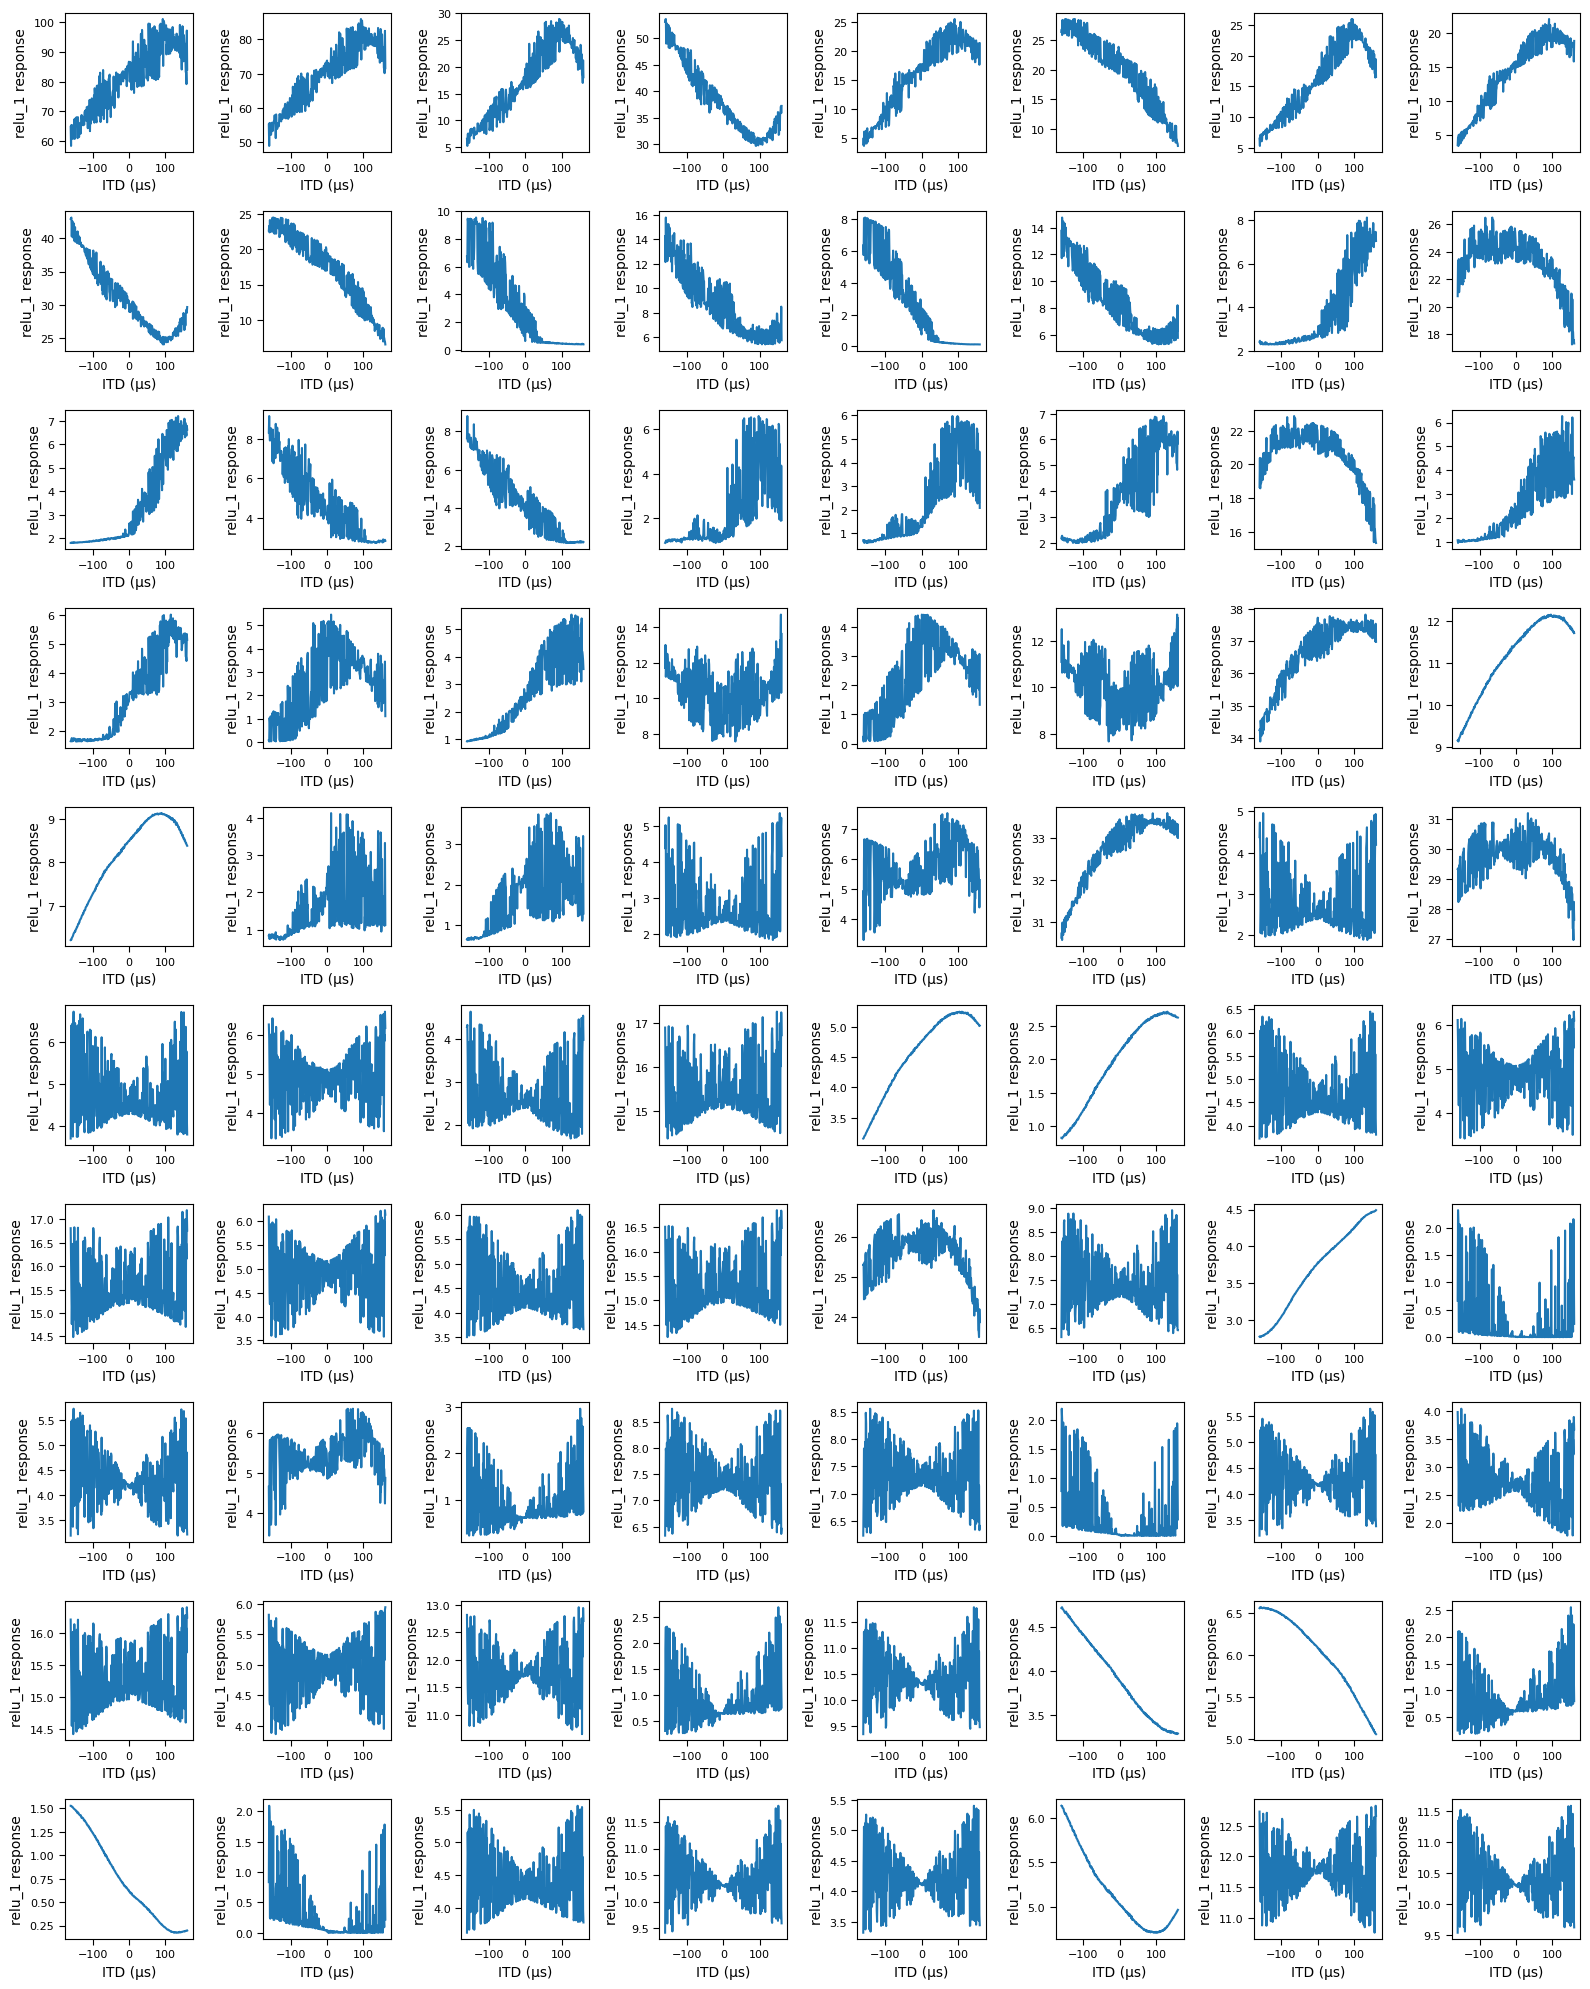

In [29]:
"""
Visualize ITD-tuning of individual units
"""

act = list_activation.copy()
print(f"Collected time-averaged activations: {act.shape=} (n_itd, model_freq, model_channel)")

act = list_activation.reshape(list_activation.shape[0], -1)
print(f"Reshaped activations: {act.shape=} (n_itd, `model_units`)")

INCLUDE_IDX = act.mean(axis=0) > 0
act = act[:, INCLUDE_IDX]
print(f"Excluded {np.sum(~INCLUDE_IDX)} units with no activity (averaged across all stimuli): {act.shape=} (n_itd, `model_units`)")

# UNIT_SORT_IDX = np.argsort(act.mean(axis=0)) # Find the units with the largest activity across all stimuli)
UNIT_SORT_IDX = np.argsort(np.var(act, axis=0)) # Find the units with the most variance across all stimuli
act = act[:, UNIT_SORT_IDX]
act = act[:, ::-1]
print(f"Sorted remaining {len(UNIT_SORT_IDX)} units by amount of variance across stimuli: {act.shape=} (n_itd, `model_units`)")


fig, ax_arr = plt.subplots(
    nrows=10,
    ncols=8,
    figsize=(16, 20),
)
ax_arr = np.array(ax_arr).reshape([-1])
print(f"\nVisualizing ITD tuning for the {len(ax_arr)} most ITD-sensitive units in {dir_model}/{activation_layer_name}:\n")
for itr_ax in range(len(ax_arr)):
    ax = ax_arr[itr_ax]
    ax.plot(1e6 * list_itd, act[:, itr_ax])
    util_figures.format_axes(
        ax,
        str_xlabel="ITD (µs)",
        str_ylabel=f"{activation_layer_name} response",
        fontsize_ticks=8,
        fontsize_labels=10,
    )
plt.tight_layout()
plt.show()
